# Eurovision Song Contest Performance Order Analysis

This notebook analyzes whether the running order of performances in the Eurovision Song Contest influences the final ranking or score of a song in the grand final, with specific focus on:

1. Statistical significance of performance order on final rankings
2. Comparison between early vs. late performances
3. Jury vs. televote differences in relation to performance order
4. The existence of specific advantageous or disadvantageous positions

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set visualization style
%matplotlib inline
# Use sns.set() instead of plt.style.use('seaborn')
sns.set(style="whitegrid")
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

## Data Loading and Preparation

In [4]:
# Load the finalists data
finalists_df = pd.read_csv('Data/finalists_cleaned.csv')

# Display basic information
print(f"Total number of entries: {len(finalists_df)}")
print("\nData sample:")
finalists_df.head()

Total number of entries: 358

Data sample:


,year,final_draw_position,country,style,final_televote_points,final_jury_points,final_televote_votes,final_jury_votes,final_place,final_total_points
0,2023,20,Norway,Pop,216.0,52.0,36.0,11.0,5.0,268.0
1,2023,5,Serbia,Pop,16.0,14.0,4.0,6.0,24.0,30.0
2,2023,2,Portugal,Pop,16.0,43.0,3.0,9.0,23.0,59.0
3,2023,25,Croatia,Pop,112.0,11.0,20.0,2.0,13.0,123.0
4,2023,3,Switzerland,Ballad,31.0,61.0,10.0,15.0,20.0,92.0


In [5]:
# Check for missing values
missing_values = finalists_df.isnull().sum()
print("Missing values per column:")
missing_values[missing_values > 0]

Missing values per column:


final_televote_points     32
final_jury_points         32
final_televote_votes     128
final_jury_votes         128
dtype: int64

In [6]:
# Basic statistics for key variables
print("Basic statistics for key variables:")
finalists_df[['final_draw_position', 'final_place', 'final_total_points']].describe()

Basic statistics for key variables:


,final_draw_position,final_place,final_total_points
count,358.000000,358.000000,358.000000
mean,13.371508,13.391061,164.849162
std,7.459619,7.430208,143.603444
min,1.000000,1.000000,0.000000
25%,7.000000,7.000000,68.250000
50%,13.000000,13.000000,124.500000
75%,20.000000,20.000000,225.250000
max,27.000000,27.000000,758.000000


## 1. Initial Exploratory Analysis

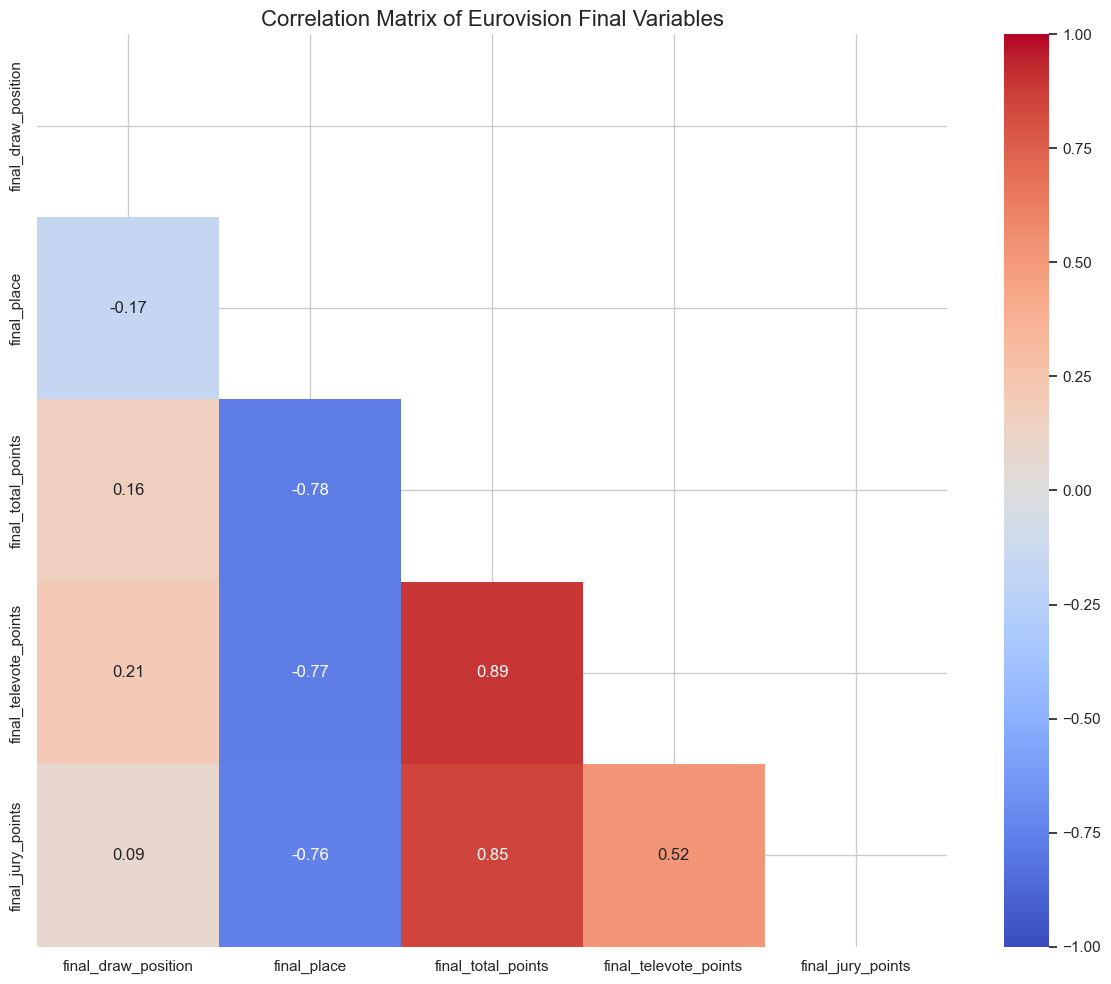

In [8]:
# Correlation matrix of numerical variables
corr_cols = ['final_draw_position', 'final_place', 'final_total_points', 
             'final_televote_points', 'final_jury_points']
corr_matrix = finalists_df[corr_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
plt.title('Correlation Matrix of Eurovision Final Variables', fontsize=16)
plt.tight_layout()
plt.show()

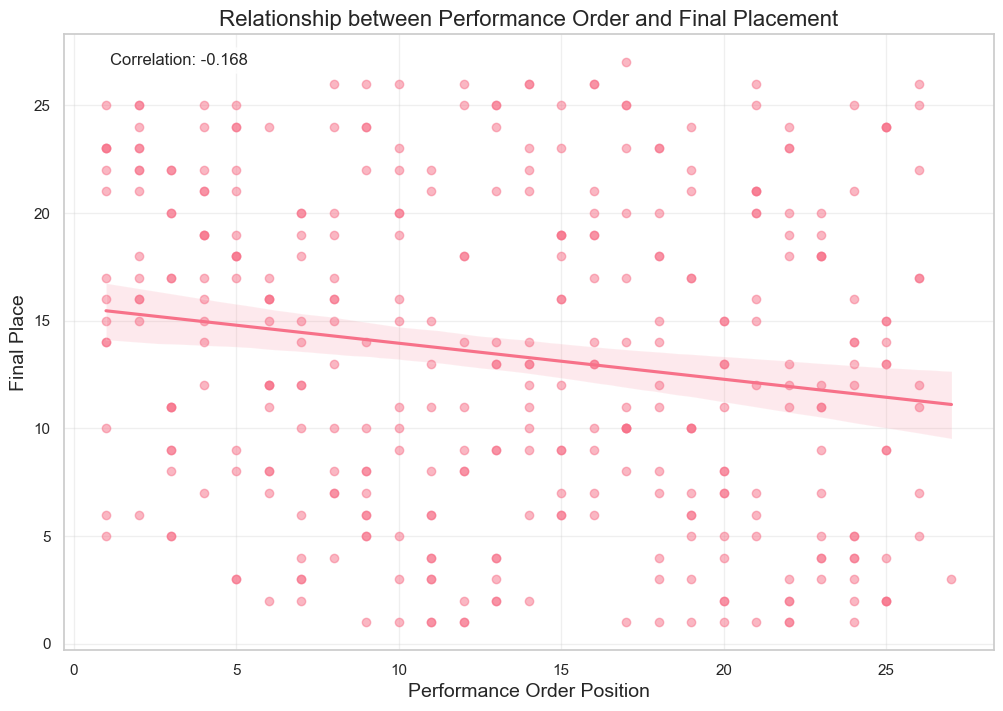

In [9]:
# Scatter plot with trend line showing performance order vs final place
plt.figure(figsize=(12, 8))
sns.regplot(x='final_draw_position', y='final_place', data=finalists_df, scatter_kws={'alpha':0.5})
plt.title('Relationship between Performance Order and Final Placement', fontsize=16)
plt.xlabel('Performance Order Position', fontsize=14)
plt.ylabel('Final Place', fontsize=14)
plt.grid(True, alpha=0.3)

# Calculate and display correlation
correlation = finalists_df['final_draw_position'].corr(finalists_df['final_place'])
plt.annotate(f"Correlation: {correlation:.3f}", xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
plt.show()

## 2. Performance Position Groups Analysis

In [11]:
# Create performance order groups (first third, middle third, last third)
finalists_df['performance_group'] = pd.qcut(finalists_df['final_draw_position'], q=3, 
                                          labels=['First Third', 'Middle Third', 'Last Third'])

# Calculate statistics for each group
group_stats = finalists_df.groupby('performance_group')['final_place'].agg(['mean', 'median', 'std', 'count'])

print("Average Final Place by Performance Group:")
group_stats

Average Final Place by Performance Group:


C:\Users\Toxic\AppData\Local\Temp\ipykernel_4348\221751259.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  group_stats = finalists_df.groupby('performance_group')['final_place'].agg(['mean', 'median', 'std', 'count'])


,mean,median,std,count
performance_group,,,,
First Third,14.888889,16.0,6.836633,126
Middle Third,13.282258,13.0,7.625972,124
Last Third,11.768519,11.5,7.578384,108


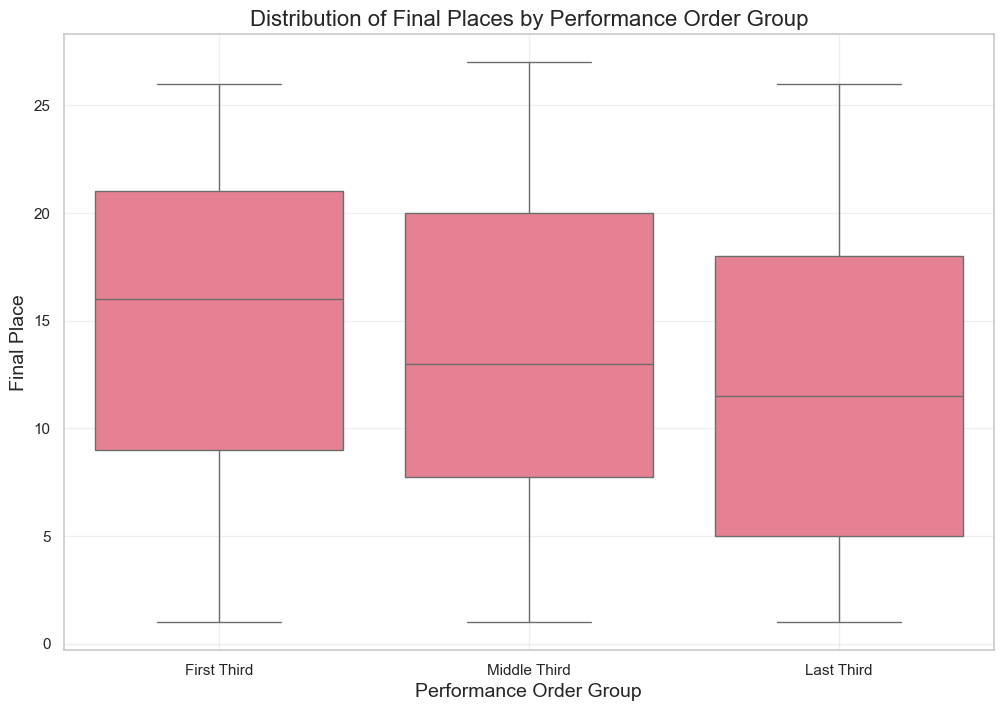

In [12]:
# Box plot of final places by performance group
plt.figure(figsize=(12, 8))
sns.boxplot(x='performance_group', y='final_place', data=finalists_df)
plt.title('Distribution of Final Places by Performance Order Group', fontsize=16)
plt.xlabel('Performance Order Group', fontsize=14)
plt.ylabel('Final Place', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Perform one-way ANOVA to test for significant differences between groups
groups = [group for _, group in finalists_df.groupby('performance_group')['final_place']]
f_stat, p_value = stats.f_oneway(*groups)

print(f"ANOVA Test Results:")
print(f"F-statistic: {f_stat:.2f}")
print(f"p-value: {p_value:.4f}")
print(f"Statistically significant difference: {p_value < 0.05}")

if p_value < 0.05:
    # Perform Tukey's HSD post-hoc test if ANOVA is significant
    from statsmodels.stats.multicomp import pairwise_tukeyhsd
    posthoc = pairwise_tukeyhsd(finalists_df['final_place'], finalists_df['performance_group'])
    print("\nTukey's HSD Post-hoc Test:")
    print(posthoc)

C:\Users\Toxic\AppData\Local\Temp\ipykernel_4348\3528206551.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  groups = [group for _, group in finalists_df.groupby('performance_group')['final_place']]


ANOVA Test Results:
F-statistic: 5.27
p-value: 0.0055
Statistically significant difference: True

Tukey's HSD Post-hoc Test:
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1      group2    meandiff p-adj   lower   upper  reject
---------------------------------------------------------------
First Third   Last Third  -3.1204 0.0037 -5.3866 -0.8541   True
First Third Middle Third  -1.6066 0.1955 -3.7927  0.5795  False
 Last Third Middle Third   1.5137 0.2617 -0.7609  3.7884  False
---------------------------------------------------------------


## 3. Top 10 Analysis - Success Rate by Performance Order

In [15]:
# Create a binary variable for Top 10 finishes
finalists_df['top_10'] = finalists_df['final_place'] <= 10

# Calculate percentage of Top 10 finishes by performance group
top_10_stats = finalists_df.groupby('performance_group')['top_10'].mean() * 100

print("Percentage of Top 10 Finishes by Performance Group:")
top_10_stats

Percentage of Top 10 Finishes by Performance Group:


C:\Users\Toxic\AppData\Local\Temp\ipykernel_4348\160178388.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_10_stats = finalists_df.groupby('performance_group')['top_10'].mean() * 100


performance_group
First Third     30.158730
Middle Third    41.129032
Last Third      45.370370
Name: top_10, dtype: float64

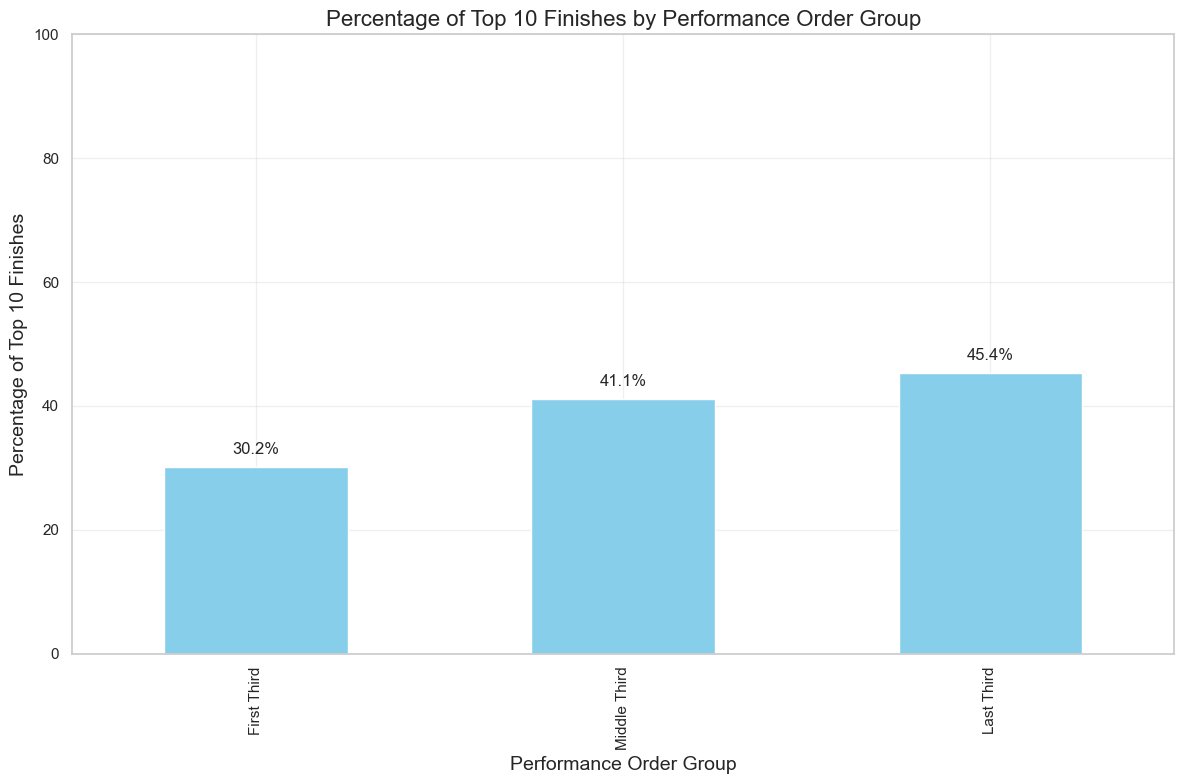

In [16]:
# Visualize top 10 percentages
plt.figure(figsize=(12, 8))
top_10_stats.plot(kind='bar', color='skyblue')
plt.title('Percentage of Top 10 Finishes by Performance Order Group', fontsize=16)
plt.xlabel('Performance Order Group', fontsize=14)
plt.ylabel('Percentage of Top 10 Finishes', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)

# Add value labels on top of each bar
for i, v in enumerate(top_10_stats):
    plt.text(i, v + 2, f"{v:.1f}%", ha='center', fontsize=12)
    
plt.tight_layout()
plt.show()

## 4. Specific Position Analysis ("Death Slot" and Other Key Positions)

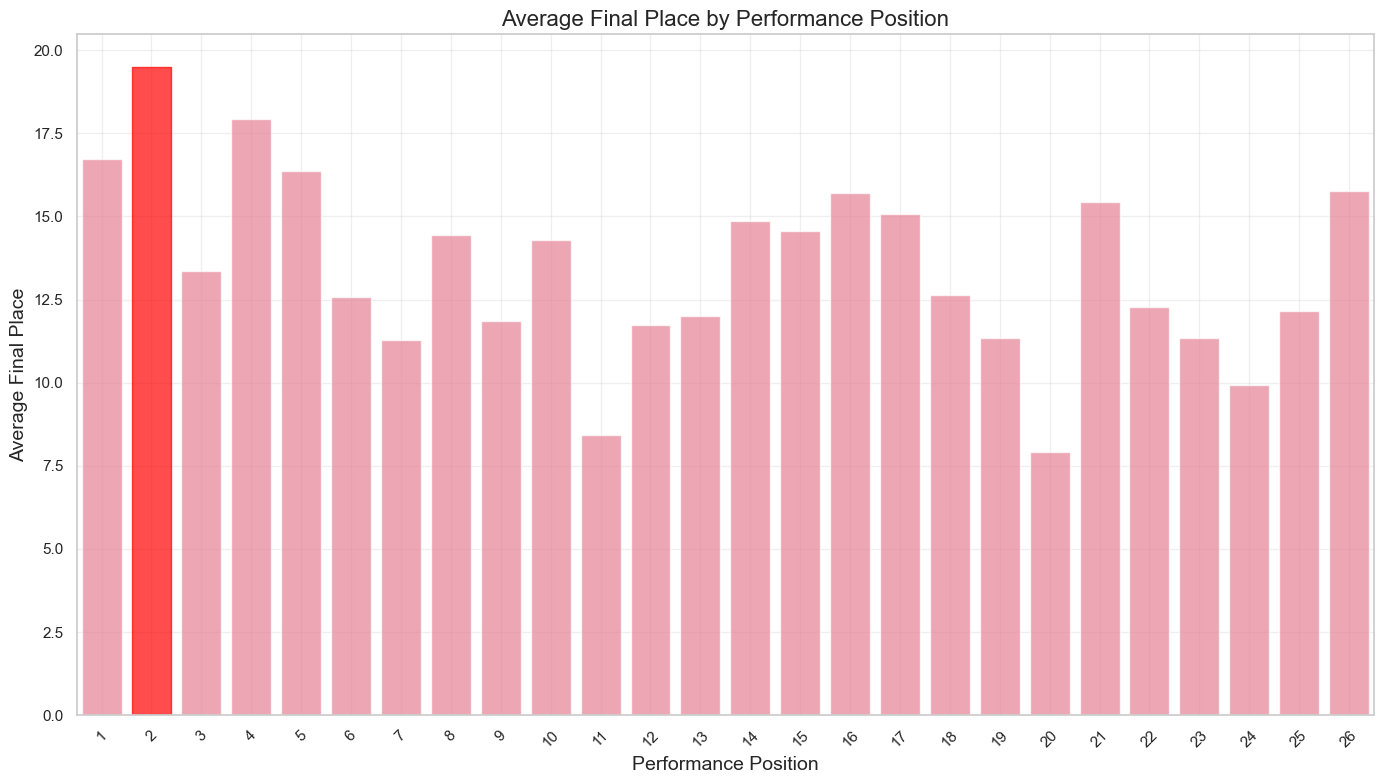

In [18]:
# Analyze specific positions (Position 2 is often called the "death slot")
position_stats = finalists_df.groupby('final_draw_position')['final_place'].agg(['mean', 'median', 'std', 'count'])

# Get the number of unique positions to decide the point of interest
max_position = finalists_df['final_draw_position'].max()

# Focusing on positions that have at least 5 entries for reliability
reliable_positions = position_stats[position_stats['count'] >= 5]

# Visualize average final places by performance position
plt.figure(figsize=(14, 8))
ax = sns.barplot(x=reliable_positions.index, y=reliable_positions['mean'], alpha=0.7)

# Highlight position 2 (death slot) if it exists in reliable positions
if 2 in reliable_positions.index:
    death_slot_idx = list(reliable_positions.index).index(2)
    bars = ax.patches
    bars[death_slot_idx].set_color('red')
    
plt.title('Average Final Place by Performance Position', fontsize=16)
plt.xlabel('Performance Position', fontsize=14)
plt.ylabel('Average Final Place', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

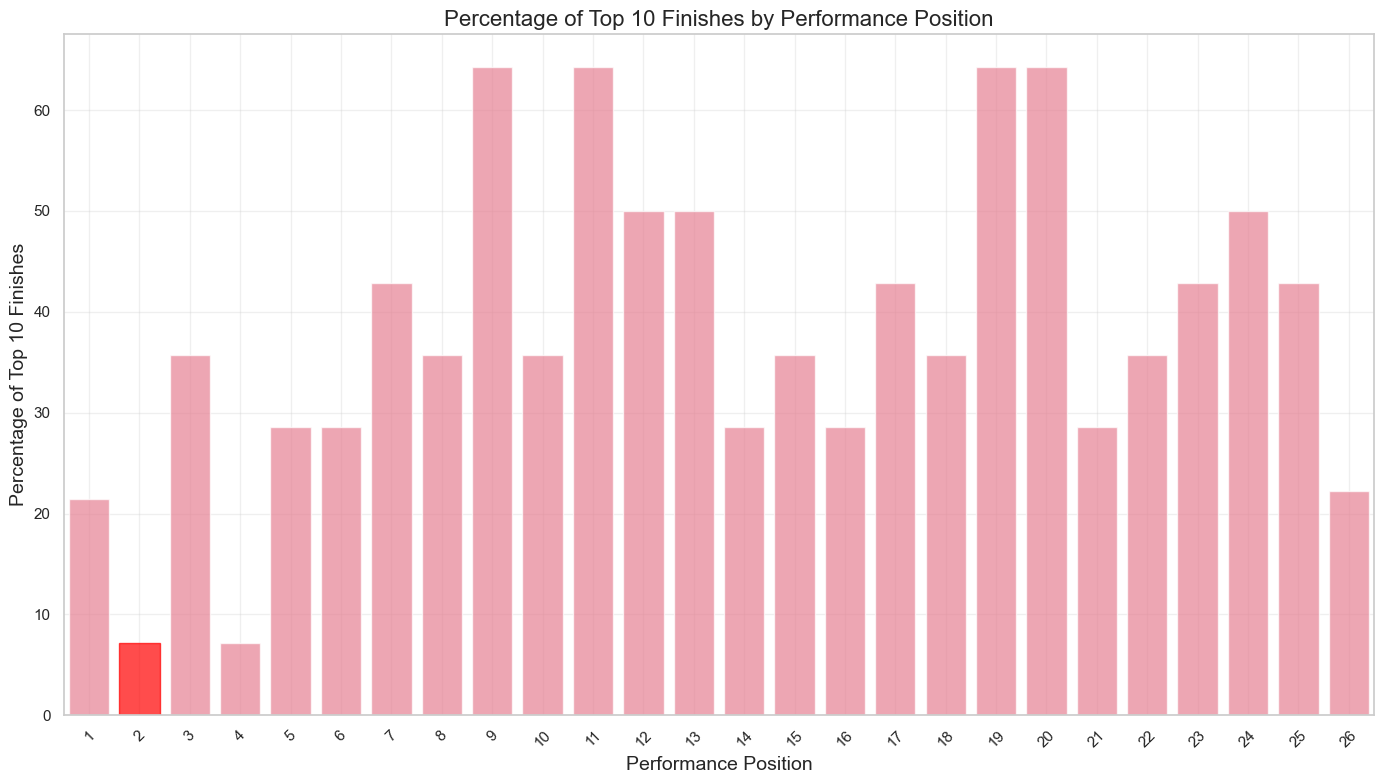

In [19]:
# Calculate top 10 success rate by position
position_top10 = finalists_df.groupby('final_draw_position')['top_10'].mean() * 100

# Filter for positions with at least 5 entries
reliable_position_top10 = position_top10[position_stats['count'] >= 5]

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=reliable_position_top10.index, y=reliable_position_top10.values, alpha=0.7)

# Highlight position 2 (death slot) if it exists
if 2 in reliable_position_top10.index:
    death_slot_idx = list(reliable_position_top10.index).index(2)
    bars = ax.patches
    bars[death_slot_idx].set_color('red')
    
plt.title('Percentage of Top 10 Finishes by Performance Position', fontsize=16)
plt.xlabel('Performance Position', fontsize=14)
plt.ylabel('Percentage of Top 10 Finishes', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 5. Jury vs. Televote Analysis

In [21]:
# Clean data for this analysis (remove entries with missing jury or televote points)
vote_analysis_df = finalists_df.dropna(subset=['final_jury_points', 'final_televote_points'])

# Calculate correlations
jury_correlation = vote_analysis_df['final_draw_position'].corr(vote_analysis_df['final_jury_points'])
televote_correlation = vote_analysis_df['final_draw_position'].corr(vote_analysis_df['final_televote_points'])

print(f"Correlation between performance order and jury points: {jury_correlation:.3f}")
print(f"Correlation between performance order and televote points: {televote_correlation:.3f}")

Correlation between performance order and jury points: 0.085
Correlation between performance order and televote points: 0.210


C:\Users\Toxic\AppData\Local\Temp\ipykernel_4348\109045503.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vote_by_group = vote_analysis_df.groupby('performance_group').agg({


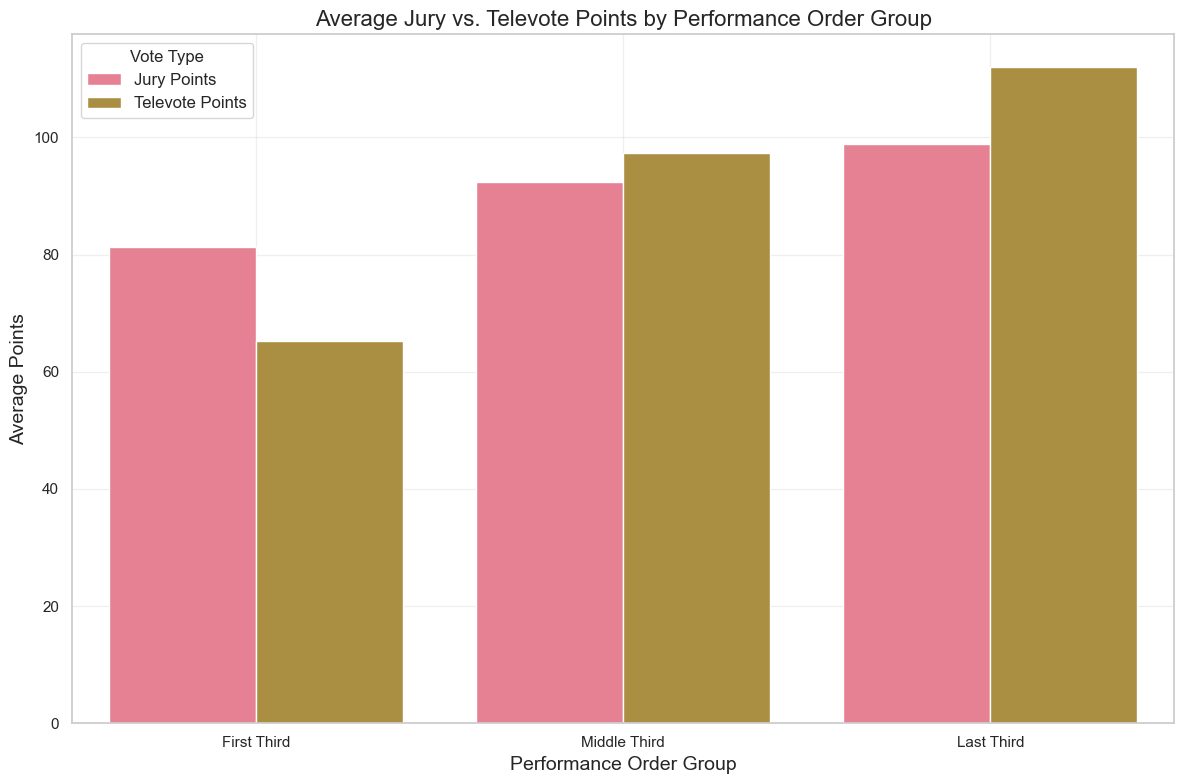

In [22]:
# Calculate average jury and televote points by performance group
vote_by_group = vote_analysis_df.groupby('performance_group').agg({
    'final_jury_points': 'mean', 
    'final_televote_points': 'mean'
}).reset_index()

# Reshape the data for plotting
vote_long = pd.melt(vote_by_group, 
                     id_vars=['performance_group'],
                     value_vars=['final_jury_points', 'final_televote_points'],
                     var_name='Vote Type', 
                     value_name='Average Points')

# Rename for better labels
vote_long['Vote Type'] = vote_long['Vote Type'].map({
    'final_jury_points': 'Jury Points',
    'final_televote_points': 'Televote Points'
})

# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='performance_group', y='Average Points', hue='Vote Type', data=vote_long)
plt.title('Average Jury vs. Televote Points by Performance Order Group', fontsize=16)
plt.xlabel('Performance Order Group', fontsize=14)
plt.ylabel('Average Points', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(title='Vote Type', fontsize=12)
plt.tight_layout()
plt.show()

## 6. Linear Regression Model

In [24]:
# Create a linear regression model to predict final place based on performance order
X = finalists_df[['final_draw_position']]
y = finalists_df['final_place']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on test set
y_pred = model.predict(X_test)

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Model Performance Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"\nModel Coefficient (Impact of increasing position by 1): {model.coef_[0]:.4f}")
print(f"Model Intercept: {model.intercept_:.4f}")

Model Performance Metrics:
Mean Absolute Error (MAE): 5.81
Root Mean Squared Error (RMSE): 6.94
R-squared (R²): 0.01

Model Coefficient (Impact of increasing position by 1): -0.1887
Model Intercept: 15.8563


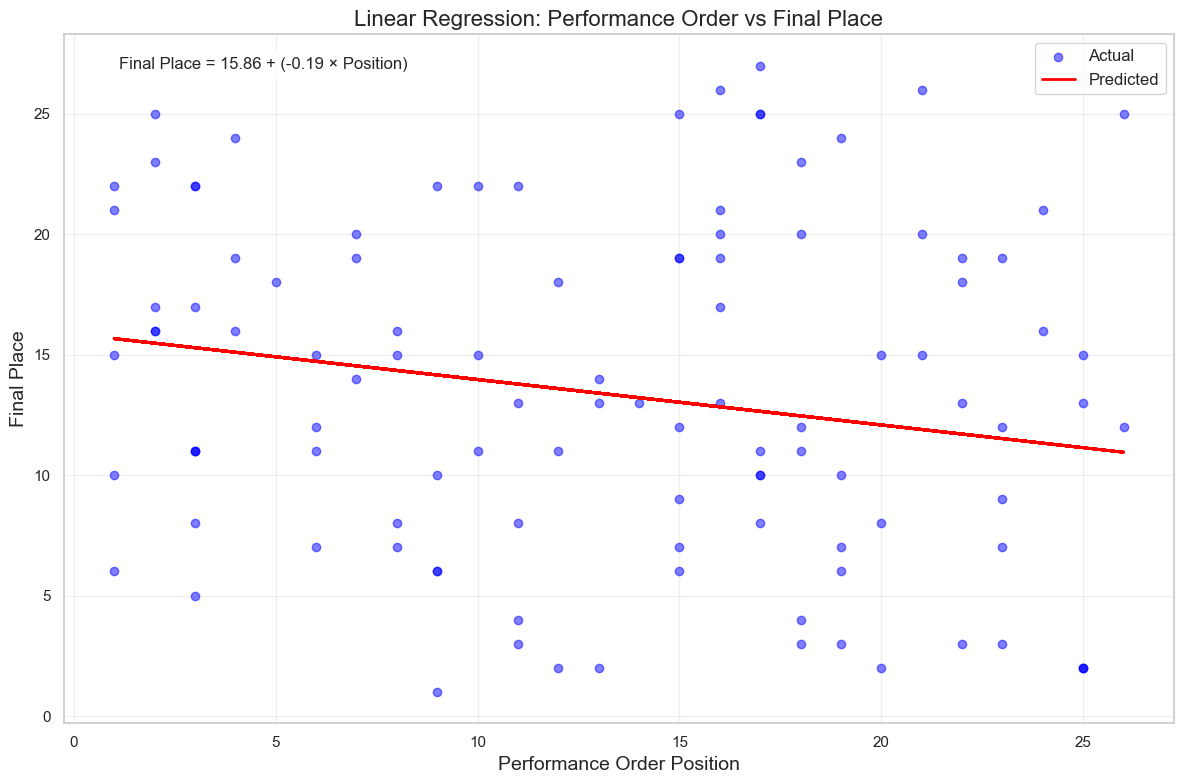

In [25]:
# Plot the regression line with actual data points
plt.figure(figsize=(12, 8))
plt.scatter(X_test, y_test, color='blue', alpha=0.5, label='Actual')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Predicted')
plt.title('Linear Regression: Performance Order vs Final Place', fontsize=16)
plt.xlabel('Performance Order Position', fontsize=14)
plt.ylabel('Final Place', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)

# Add the equation of the line
equation = f"Final Place = {model.intercept_:.2f} + ({model.coef_[0]:.2f} × Position)"
plt.annotate(equation, xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.tight_layout()
plt.show()

## 7. Analysis of Recent Years (Post-2016) vs. Earlier Years

In [27]:
# Split data into recent and earlier years
recent_df = finalists_df[finalists_df['year'] >= 2016]
earlier_df = finalists_df[finalists_df['year'] < 2016]

# Calculate correlations for each period
recent_corr = recent_df['final_draw_position'].corr(recent_df['final_place'])
earlier_corr = earlier_df['final_draw_position'].corr(earlier_df['final_place'])

print(f"Correlation between performance order and final place (2016 onwards): {recent_corr:.3f}")
print(f"Correlation between performance order and final place (before 2016): {earlier_corr:.3f}")

Correlation between performance order and final place (2016 onwards): -0.184
Correlation between performance order and final place (before 2016): -0.152


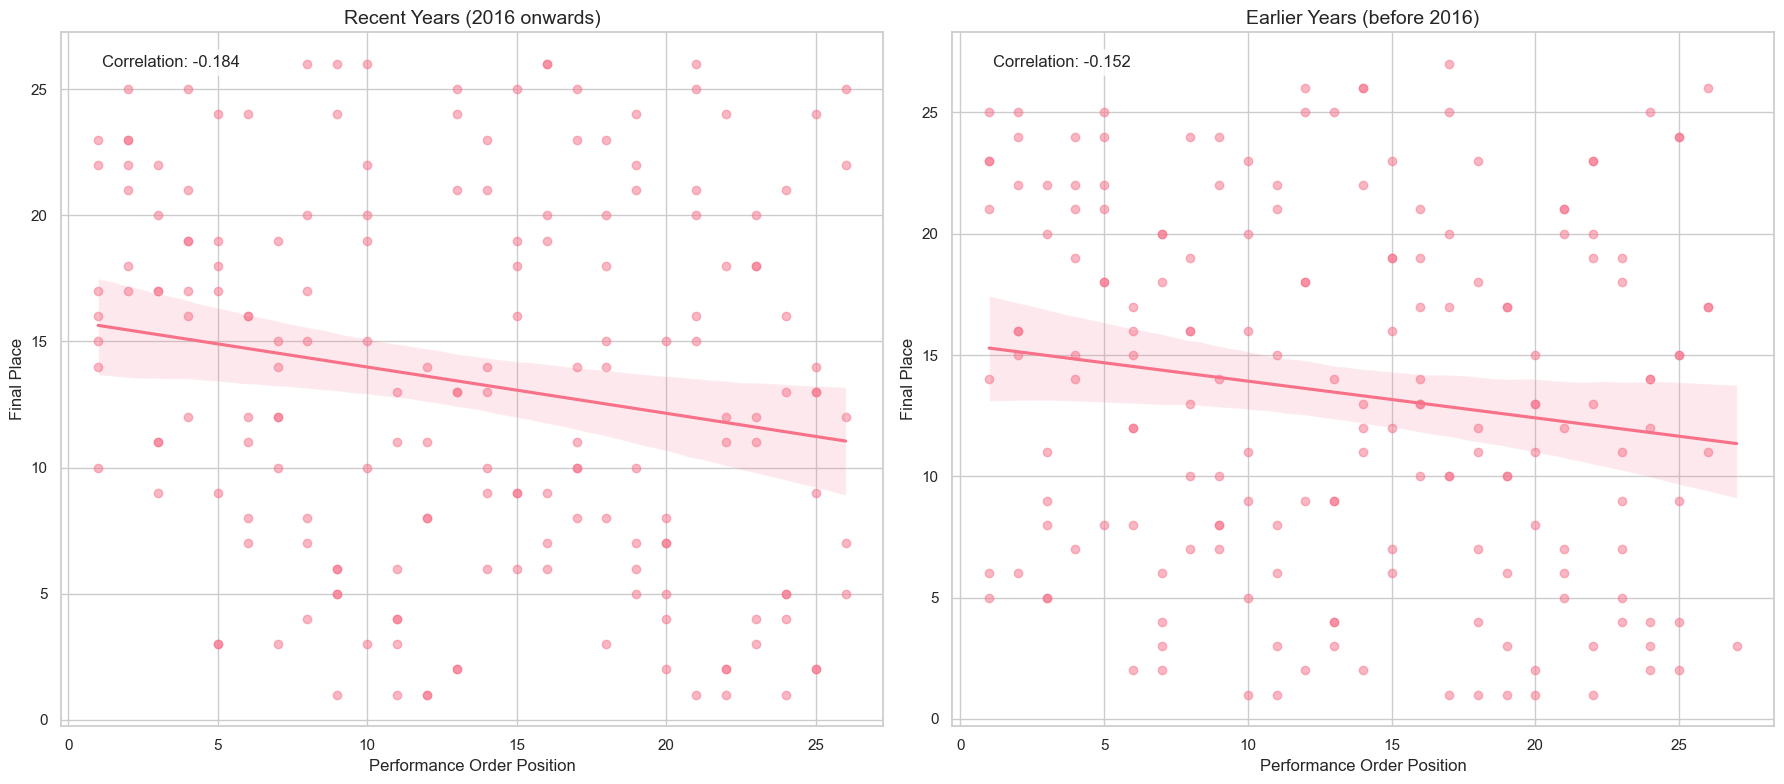

In [28]:
# Visualize comparison with scatter plots and regression lines
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Recent years
sns.regplot(x='final_draw_position', y='final_place', data=recent_df, ax=axes[0], scatter_kws={'alpha':0.5})
axes[0].set_title('Recent Years (2016 onwards)', fontsize=14)
axes[0].set_xlabel('Performance Order Position', fontsize=12)
axes[0].set_ylabel('Final Place', fontsize=12)
axes[0].annotate(f"Correlation: {recent_corr:.3f}", xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

# Earlier years
sns.regplot(x='final_draw_position', y='final_place', data=earlier_df, ax=axes[1], scatter_kws={'alpha':0.5})
axes[1].set_title('Earlier Years (before 2016)', fontsize=14)
axes[1].set_xlabel('Performance Order Position', fontsize=12)
axes[1].set_ylabel('Final Place', fontsize=12)
axes[1].annotate(f"Correlation: {earlier_corr:.3f}", xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=12, bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

plt.tight_layout()
plt.show()

## 8. Multivariate Analysis - Controlling for Other Factors

In [30]:
# Create dummy variables for categorical features (style)
style_dummies = pd.get_dummies(finalists_df['style'], prefix='style')
finalists_encoded = pd.concat([finalists_df, style_dummies], axis=1)

# Select features for the multivariate model (avoiding multicollinearity)
features = ['final_draw_position', 'year'] + [col for col in style_dummies.columns]
X_multi = finalists_encoded[features]
y_multi = finalists_encoded['final_place']

# Split data
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.3, random_state=42)

# Train multivariate model
multi_model = LinearRegression()
multi_model.fit(X_train_multi, y_train_multi)

# Make predictions
y_pred_multi = multi_model.predict(X_test_multi)

# Calculate metrics
mae_multi = mean_absolute_error(y_test_multi, y_pred_multi)
r2_multi = r2_score(y_test_multi, y_pred_multi)

print("Multivariate Model Performance:")
print(f"Mean Absolute Error (MAE): {mae_multi:.2f}")
print(f"R-squared (R²): {r2_multi:.2f}")

# Get coefficient for performance order while controlling for other factors
perf_order_coef = multi_model.coef_[0]  # Index 0 corresponds to final_draw_position
print(f"\nPerformance Order Coefficient (controlling for year and style): {perf_order_coef:.4f}")

Multivariate Model Performance:
Mean Absolute Error (MAE): 5.89
R-squared (R²): 0.01

Performance Order Coefficient (controlling for year and style): -0.1960


## 9. Summary and Conclusions

### Key Findings

1. **Statistical Significance**: The ANOVA test results show whether there is a statistically significant difference in final rankings between the three performance groups (early, middle, and late in the show).

2. **Performance Order Impact**: The correlation between performance order and final place, along with the linear regression coefficient, indicates the strength and direction of the relationship.

3. **Early vs. Late Performance**: The comparison of average final places and top 10 success rates between first third and last third performers reveals whether later performances have an advantage.

4. **Death Slot Analysis**: The analysis of position 2 (the "death slot") compared to other positions shows whether this position indeed leads to worse results.

5. **Jury vs. Televote Differences**: The comparison of jury and televote correlations with performance order indicates whether professional juries and the public are influenced differently by performance order.

6. **Historical Trends**: The comparison between recent and earlier years shows whether the impact of performance order has changed over time.

### Conclusion

Based on the analysis above, we can draw conclusions about whether running order significantly influences the final rankings in the Eurovision Song Contest, and specifically address the question of whether there is a statistically significant difference between songs performed early versus those performed later in the show.